Copyright 2022 The Zimtohrli Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import json
import numpy as np
import scipy
import matplotlib.pyplot as plt
import glob

In [3]:
def each_pair(references):
    for ref in references:
        for dist in ref["Distortions"]:
            if "Zimtohrli" in dist["Scores"] and "MOS" in dist["Scores"]:
                yield (float(dist["Scores"]["MOS"]), float(dist["Scores"]["Zimtohrli"]))


def each_normalized_pair(references):
    min_mos = None
    max_mos = None
    for mos, _ in each_pair(references):
        if min_mos is None or mos < min_mos:
            min_mos = mos
        if max_mos is None or mos > max_mos:
            max_mos = mos
    if min_mos and max_mos:
        mos_range_reciprocal = 1.0 / (max_mos - min_mos)
        for mos, z in each_pair(references):
            yield (1 + (mos - min_mos) * 4 * mos_range_reciprocal, z)


z_scores = []
mos_scores = []
with open("../scores.json") as json_file:
    for data_set in json.load(json_file):
        for mos, z in each_normalized_pair(data_set["References"]):
            z_scores.append(z)
            mos_scores.append(mos)

z_scores = np.asarray(z_scores)
mos_scores = np.asarray(mos_scores)
mos_extremes = np.asarray([np.max(mos_scores), np.min(mos_scores)])
z_extremes = np.asarray([np.max(z_scores), np.min(z_scores)])

print(f"{z_scores.shape=}")
print(f"{mos_scores.shape=}")
print(f"{mos_extremes=}")
print(f"{z_extremes=}")


z_scores.shape=(2990,)
mos_scores.shape=(2990,)
mos_extremes=array([5., 1.])
z_extremes=array([0.94465321, 0.        ])


res=  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 45.192310319301704
        x: [ 1.000e+00 -7.449e-09  3.344e+00]
      nit: 17
      jac: [ 0.000e+00  5.536e-04  0.000e+00]
 hess_inv: [[ 1.000e+00  3.961e-07 -6.590e-04]
            [ 3.961e-07  3.654e-09  8.073e-08]
            [-6.590e-04  8.073e-08  4.317e-01]]
     nfev: 416
     njev: 101


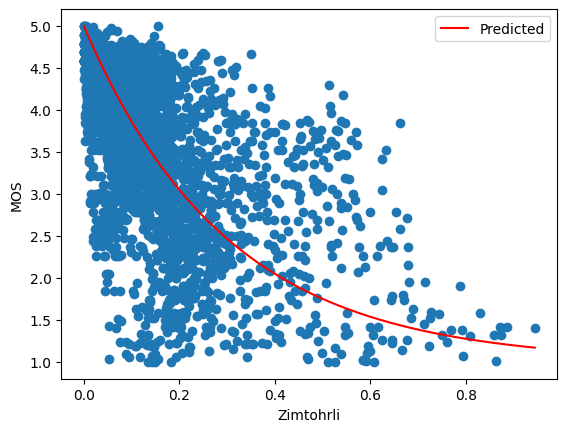

In [4]:


def sigmoid(x, params):
    return np.abs(params[0]) / (np.abs(params[1]) + np.exp(np.abs(params[2] * x)))


def sigmoid_combination(z_score, params):
    return sigmoid(z_score, params[0:3])


def predict(z_score, params):
    zero_crossing = sigmoid_combination(0, params)
    return 1 + 4 * sigmoid_combination(z_score, params) / zero_crossing


def loss(params):
    return np.linalg.norm(mos_scores - predict(z_scores, params))


res = scipy.optimize.minimize(loss, np.ones((3,)), method='BFGS')
print(f"{res=}")
plt.scatter(z_scores, mos_scores)
x = np.linspace(0, z_extremes[0], 1000)
plt.plot(x, predict(x, res.x), "r", label="Predicted")
plt.xlabel("Zimtohrli")
plt.ylabel("MOS")
plt.legend()
plt.show()